In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Loading the dataset as is with a WeightedRandomSampler to oversample classes

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the transformation: resize to 224x224, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.ToTensor()
])

# Path to your dataset folder (containing subfolders 'no_dr' and 'with_dr')
data_dir = '/Users/jeff/code/dataset/dr/binary_data'

# Load the dataset with ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Classes:", full_dataset.classes)  # Expected output: ['no_dr', 'with_dr']

# Calculate the sizes for the training and validation sets (80:20 split)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# --- Oversampling code for the training set ---
# Extract the labels for each sample in the training subset
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

# Compute the count for each class in the training set
class_counts = np.bincount(train_labels)
print("Training set class counts:", class_counts)

# Calculate weights for each class (inverse frequency)
weights_per_class = 1.0 / class_counts

# Assign a weight to each sample in the training subset based on its class label
samples_weights = [weights_per_class[label] for label in train_labels]
samples_weights = torch.DoubleTensor(samples_weights)

# Create the WeightedRandomSampler for the training DataLoader
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# Create DataLoaders using the sampler for the training set and standard shuffling for validation set
train_dl = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
valid_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Total images: {dataset_size}, Training: {train_size}, Validation: {val_size}")


Classes: ['no_dr', 'with_dr']
Training set class counts: [20653 22323]
Total images: 53720, Training: 42976, Validation: 10744


### Building The RSG_Net CNN Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- CBAM Implementation ---

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction, in_planes, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Along channel axis: compute average and max
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, in_planes, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_planes, reduction)
        self.spatial_att = SpatialAttention(kernel_size)
        
    def forward(self, x):
        # Apply channel attention
        out = x * self.channel_att(x)
        # Apply spatial attention
        out = out * self.spatial_att(out)
        return out

# --- Updated CNN Architecture with CBAM ---

class RSGNet224_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(RSGNet224_CBAM, self).__init__()
        
        # --- Block 1 ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.3)
        self.cbam1 = CBAM(in_planes=32)  # CBAM for Block 1
        
        # --- Block 2 ---
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.cbam2 = CBAM(in_planes=128)  # CBAM for Block 2
        
        self.flatten = nn.Flatten()
        # After two poolings: 224 -> 112 -> 56; feature map size: 128 x 56 x 56
        self.fc1 = nn.Linear(128 * 56 * 56, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)  # Output 2 logits for binary classification

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.cbam1(x)  # Apply CBAM after Block 1

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.cbam2(x)  # Apply CBAM after Block 2

        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


### Assigning to the device

In [6]:
# Example using the class-based approach from the RSGNet224 snippet:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = RSGNet224_CBAM(num_classes=2)  # Instantiate your model class
model = model.to(device)          # Move model parameters to the selected device

### Training the Model With Adam optimizer

In [4]:
# For binary classification, define class weights (example values; adjust as needed)
weights = torch.tensor([1.0, 2.0], dtype=torch.float)
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item() * y_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_corrects += (preds == y_batch).float().sum().cpu().item()

        loss_hist_train[epoch] = running_loss / len(train_dl.dataset)
        accuracy_hist_train[epoch] = running_corrects / len(train_dl.dataset)
        
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)
                
                running_loss_val += loss.item() * y_batch.size(0)
                preds = torch.argmax(outputs, dim=1)
                running_corrects_val += (preds == y_batch).float().sum().cpu().item()

        loss_hist_valid[epoch] = running_loss_val / len(valid_dl.dataset)
        accuracy_hist_valid[epoch] = running_corrects_val / len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} - Train accuracy: {accuracy_hist_train[epoch]:.4f}, Val accuracy: {accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 - Train accuracy: 0.7300, Val accuracy: 0.8028
Epoch 2 - Train accuracy: 0.7868, Val accuracy: 0.8221
Epoch 3 - Train accuracy: 0.7980, Val accuracy: 0.8207
Epoch 4 - Train accuracy: 0.8045, Val accuracy: 0.8201
Epoch 5 - Train accuracy: 0.7995, Val accuracy: 0.8196


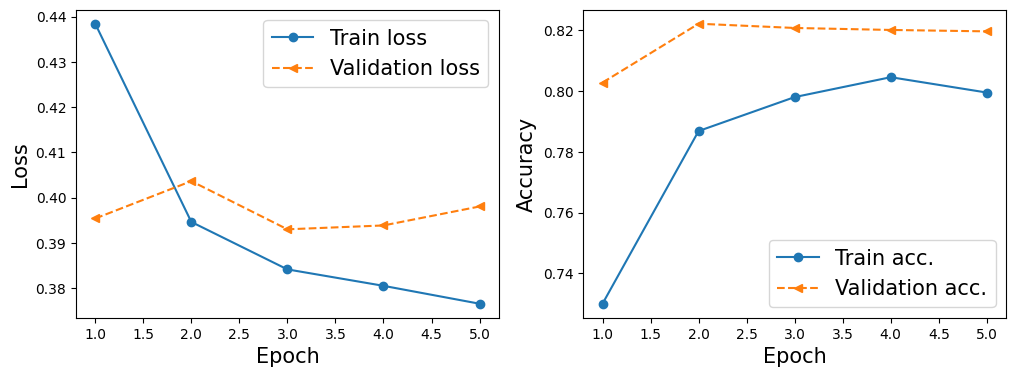

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

### Per-class metrics

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)

# Evaluate on the validation set
y_true, y_pred = evaluate_model(model, valid_dl, device)

# Print per-class metrics (precision, recall, F1-score)
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(2)]))

# Optionally, compute the confusion matrix to calculate sensitivity and specificity manually
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute per-class sensitivity (Recall) and specificity
num_classes = cm.shape[0]
sensitivity = {}
specificity = {}
for i in range(num_classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("Per-class Sensitivity (Recall):", sensitivity)
print("Per-class Specificity:", specificity)


              precision    recall  f1-score   support

           0       0.74      0.97      0.84      5188
           1       0.96      0.68      0.80      5556

    accuracy                           0.82     10744
   macro avg       0.85      0.82      0.82     10744
weighted avg       0.85      0.82      0.82     10744

Confusion Matrix:
[[5016  172]
 [1766 3790]]
Per-class Sensitivity (Recall): {0: np.float64(0.9668465690053971), 1: np.float64(0.6821454283657308)}
Per-class Specificity: {0: np.float64(0.6821454283657308), 1: np.float64(0.9668465690053971)}


#### Confusion Matrix

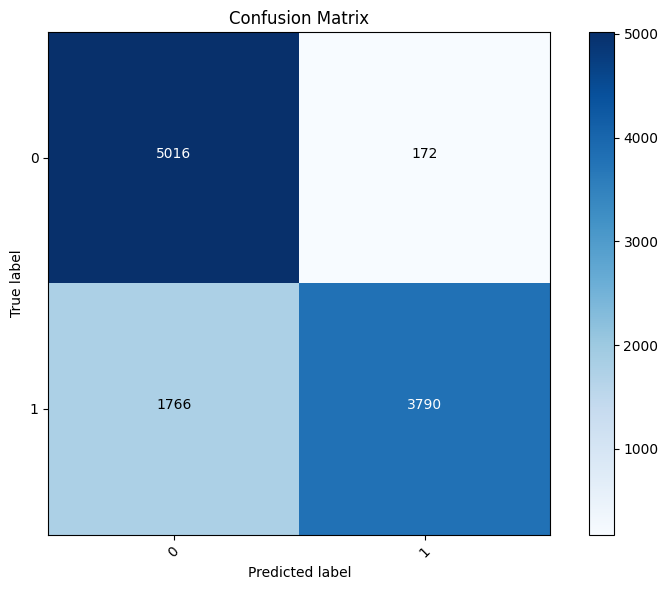

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Annotate each cell with the numeric value
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume 'cm' is your confusion matrix and you have 5 classes (0-4)
class_names = [str(i) for i in range(2)]
plot_confusion_matrix(cm, class_names)